<a href="https://colab.research.google.com/github/jenkoj/nilm-gaf/blob/main/gaf_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold


from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D


In [ ]:
ls

sample_data/


In [7]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs

#check if we are in cloud or in PC
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/"
except:
    print("reading from HDD")
    path = "D:/jjenko/nilm data/GAF_DS"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
reading from cloud...
file exists, reading it...


In [8]:
def basic_cnn_functional(X_train, num_classes, lr):
    
    input1 = Input(shape = X_train.shape[1: ])
    cnn = Conv2D(filters = 32, kernel_size = (7,7), strides = (2,2), activation='relu', padding = 'same')(input1)
    cnn1 = Conv2D(filters = 16, kernel_size =  (7,7), strides = (2,2), activation='relu', padding = 'same')(cnn)
    cnn2 = Conv2D(filters = 16, kernel_size =  (7,7), strides = (1,1), activation='relu', padding = 'same')(cnn1)
    cnn3 = Conv2D(filters = 8, kernel_size =  (7,7), strides = (1,1), activation='relu', padding = 'same')(cnn2)
    cnn4 = Conv2D(filters = 4, kernel_size =  (7,7), strides = (1,1), padding = 'same')(cnn3)
    act = Activation('relu')(cnn3)
    maxP = MaxPooling2D(pool_size = (2,2))(act)

    # prior layer should be flattend to be connected to dense layers
    Flatt = Flatten()(maxP)
    # dense layer with 50 neurons
    dense = Dense(32, activation = 'relu')(Flatt)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)#lahko SGD uporabs tud
    model = keras.models.Model(inputs=input1, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model    


In [ ]:
file.close()

In [ ]:
def transfer_learning(X_train, num_classes, lr):
    base_model = keras.applications.ResNet50V2(
        weights=None,#'imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(300, 300, 1),
        include_top=False)  # Do not include the ImageNet classifier at the top.

    base_model.trainable = True

    inputs = keras.Input(shape = X_train.shape[1: ])
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.

    x = base_model(inputs, training=True)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]


In [ ]:
#manualy_selected_appliances = ["computer monitor", "laptop computer", "washer dryer", "microwave","oven","boiler","toaster","kettle"]
#manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]

enc_appliances = np.array(file["classes/appliances"])
manualy_selected_appliances  = [n.decode("utf-8") for n in enc_appliances]
print(len(manualy_selected_appliances))
print(manualy_selected_appliances)
#anualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","oven","boiler","toaster","kettle","fridge"]

train_data = np.array(read_many_hdf5("data","gasf"))
label_data = np.array(read_many_hdf5("labels","gaf"))

print(label_data.shape)
print(train_data.shape)

9
['computer monitor', 'laptop computer', 'television', 'washer dryer', 'microwave', 'boiler', 'toaster', 'kettle', 'fridge']


KeyError: ignored

In [ ]:
train_data = read_many_hdf5("washer dryer","gasf")
train_data = np.empty([0,300,300,1])# -> change size to match GAF image size
label_data = np.empty([0,1],dtype=object)# -> change size to match GAF image size
tmp = np.empty([1,1],dtype=object)# -> change size to match GAF image size

#generate labels and read data
for appliance in manualy_selected_appliances:
  data = np.array(read_many_hdf5(f"{appliance}","gasf"))
  data = data[...,np.newaxis]
  train_data = np.append(train_data,data,axis=0)
  labels = np.repeat(np.array([[f"{manualy_selected_appliances.index(appliance)}"]],dtype=object),data.shape[0],axis=0)
  label_data = np.append(label_data,labels,axis=0)

print(label_data.shape)
print(train_data.shape)

(2700, 1)
(2700, 300, 300, 1)


In [ ]:
num_frames = train_data.shape[0]
shape_x = train_data.shape[1]
shape_y = train_data.shape[2]
channel = train_data.shape[3]

acc_per_fold = []
loss_per_fold = []

num_of_classes = len(manualy_selected_appliances)


y_anomF = tf.keras.utils.to_categorical(label_data, num_classes=num_of_classes) #onehot encoding
X_resampled = train_data.reshape(train_data.shape[0],300, 300,1)
print(X_resampled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_anomF, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


class_weights = {0: 1.,
                1: 1.,
                2: 1.,
                3: 1.,
                4: 1.,
                5: 1.,
                6: 1.,
                7: 1.,
                8: 1.,
                9: 1,
                10: 1}


skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_resampled)

for train_index, test_index in skf.split(X_resampled, y_anomF.argmax(1)):
  print("TRAIN:", train_index, "TEST:", test_index[0])
  X_train, X_test = X_resampled[train_index], X_resampled[test_index]
  y_train, y_test = y_anomF[train_index], y_anomF[test_index]

  print("xtrain, ",X_train.shape)
  print("xtest, ",X_test.shape)
  print("ytrain",y_train.shape)
  
  model = None # Clearing the NN.
  #model = basic_cnn_functional(X_train, num_of_classes, lr = 0.001)
  model = transfer_learning(X_train,num_of_classes,lr = 0.001)

  model.fit(X_train, y_train, batch_size = 16, epochs = 25, verbose = 1, class_weight=class_weights)
  results = model.evaluate(X_test, y_test, verbose = 2)

  acc_per_fold.append(round(results[1] * 100,2))
  loss_per_fold.append(round(results[0],2))
  
  print('Test accuracy: ',acc_per_fold[-1])
  print('Test loss: ',loss_per_fold[-1])

(2700, 300, 300, 1)
(2160, 300, 300, 1)
(540, 300, 300, 1)
(2160, 9)
TRAIN: [  60   61   62 ... 2697 2698 2699] TEST: 0
xtrain,  (2160, 300, 300, 1)
xtest,  (540, 300, 300, 1)
ytrain (2160, 9)
Epoch 1/25
135/135 [==============================] - 91s 603ms/step - loss: 21.7417 - accuracy: 0.1493
Epoch 2/25
135/135 [==============================] - 81s 603ms/step - loss: 2.8205 - accuracy: 0.2980
Epoch 3/25
135/135 [==============================] - 81s 602ms/step - loss: 1.7535 - accuracy: 0.3763
Epoch 4/25
135/135 [==============================] - 81s 603ms/step - loss: 1.5658 - accuracy: 0.4340
Epoch 5/25
135/135 [==============================] - 81s 602ms/step - loss: 1.4609 - accuracy: 0.4880
Epoch 6/25
135/135 [==============================] - 81s 602ms/step - loss: 1.2850 - accuracy: 0.5197
Epoch 7/25
135/135 [==============================] - 81s 602ms/step - loss: 1.1901 - accuracy: 0.5532
Epoch 8/25
135/135 [==============================] - 81s 603ms/step - loss: 1.1108 -

In [ ]:
print(acc_per_fold)
print(loss_per_fold)
#RESULTS !
#gadf 5 folds 25 epochs
#[56.3, 53.52, 53.33, 57.41, 56.85]
#[2.52, 3.58, 2.74, 3.3, 3.45]
#gasf 5 folds 25 epocks
#[50.74, 46.3, 42.22, 42.78, 45.74]
#[3.14, 3.36, 4.38, 2.82, 3.01]

[50.74, 46.3, 42.22, 42.78, 45.74]
[3.14, 3.36, 4.38, 2.82, 3.01]


In [ ]:
num_frames = train_data.shape[0]
shape_x = train_data.shape[1]
shape_y = train_data.shape[2]
channel = train_data.shape[3]

num_of_classes = len(manualy_selected_appliances)


y_anomF = tf.keras.utils.to_categorical(label_data, num_classes=num_of_classes) #onehot encoding
X_resampled = train_data.reshape(train_data.shape[0],300, 300,1)
print(X_resampled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_anomF, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)



class_weights = {0: 1.,
                1: 1.,
                2: 1.,
                3: 1.,
                4: 1.,
                5: 1.,
                6: 1.,
                7: 1.,
                8: 1.,
                9: 1,
                10: 1}

#load model, add training data, n of classes and learning rate
model = basic_cnn_functional(X_train, num_of_classes, lr = 0.001)
#model = transfer_learning(X_train,num_of_classes,lr = 0.001)

model.fit(X_train, y_train, batch_size = 16, validation_split = 0.2, epochs = 20, verbose = 1, class_weight=class_weights)

results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
cf_matrix = confusion_matrix(Y_test, y_pred, )
print(cf_matrix)
print(classification_report(Y_test, y_pred, target_names=manualy_selected_appliances))
#precision for various datassets - to see if more data helps
#window times for various appliances

(2700, 300, 300, 1)
(2160, 300, 300, 1)
(2160, 9)
Epoch 1/20
108/108 [==============================] - 45s 73ms/step - loss: 2.0851 - accuracy: 0.1664 - val_loss: 1.5399 - val_accuracy: 0.3981
Epoch 2/20
108/108 [==============================] - 7s 68ms/step - loss: 1.4816 - accuracy: 0.4186 - val_loss: 1.4091 - val_accuracy: 0.4514
Epoch 3/20
108/108 [==============================] - 7s 68ms/step - loss: 1.3129 - accuracy: 0.4638 - val_loss: 1.3013 - val_accuracy: 0.4861
Epoch 4/20
108/108 [==============================] - 7s 68ms/step - loss: 1.2439 - accuracy: 0.4999 - val_loss: 1.4948 - val_accuracy: 0.4352
Epoch 5/20
108/108 [==============================] - 7s 69ms/step - loss: 1.1266 - accuracy: 0.5635 - val_loss: 1.3481 - val_accuracy: 0.5000
Epoch 6/20
108/108 [==============================] - 7s 68ms/step - loss: 0.9835 - accuracy: 0.6080 - val_loss: 1.4418 - val_accuracy: 0.5093
Epoch 7/20
108/108 [==============================] - 7s 68ms/step - loss: 0.8682 - accurac

29/29 - 1s


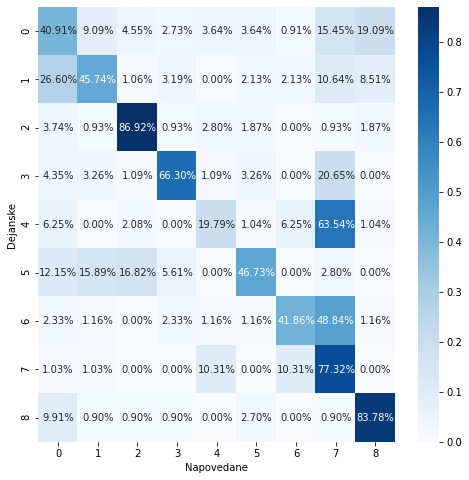

In [ ]:
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
cm = confusion_matrix(Y_test, y_pred)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(cmn, fmt=".2%", annot=True, cmap='Blues')
plt.ylabel('Dejanske')
plt.xlabel('Napovedane')
plt.show(block=False)

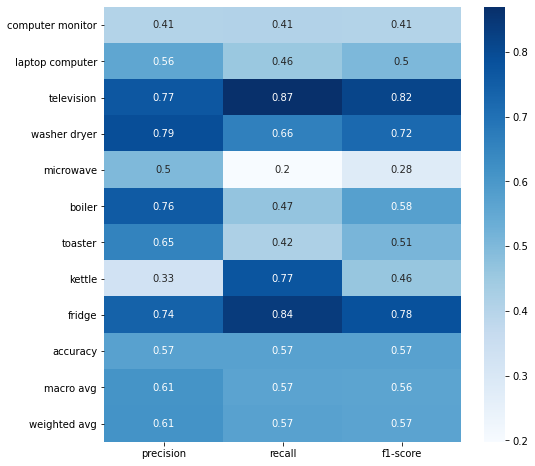

In [ ]:
labels_krneki = np.arange(9)

clf_report = classification_report(Y_test,
                                   y_pred,
                                   labels=labels_krneki,
                                   target_names=manualy_selected_appliances,
                                   output_dict=True)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap="Blues")



In [ ]:
f